# COMP47700 Speech and Audio PL3: Speech analysis and feature extraction
---
## Learning outcomes
This practical tutorial covers the following learning outcomes within the COMP47700 Speech and Audio module:
* Analyse speech and audio signals and features (**LO1**)
  * Carry out an analysis of speech wav files using spectrogram plots and varying key parameters like `offset`, `duration`, and `n_fft`.
* Articulate the characteristics of speech, speech production and speech understanding (**LO2**)
  * Compute the spectrum for speech signals and extract the frequency formants (F1 and F2) and the fundamental frequency (F0) using `librosa`.
* Describe the signal characteristics of speech and audio signals using appropriate terminology (**LO3**)
  * Visualise and explore the distribution of frequency formants (F1, F2)  and the fundamental frequency (F0) for different speech utterances.
* Create programmes to conduct experiments on speech and audio samples building on third software libraries (**LO6**)
  * Download and extract compressed datasets from an external source using Python libraries.
  * Setup and organise files for data analysis using `pandas` dataframes.

## Module topics
This practical tutorial builds on the following core topics:
* Speech production, characteristics of speech and structure of speech (Unit 3)
* How we hear, speech auditory perception (Unit 4)

## Why is this important?
After gaining familiarity with basic tools in Python to read, manipulate and generate audio and speech digital signals, this practical tutorial explores speech signals characteristics and speech production. A solid understanding of these concepts is foundational for developing effective and accurate applications in Python, particularly in the fields of speech processing, natural language processing, machine learning, and audio signal processing.

## Structure of this tutorial
This practical tutorial contains different sections:
* **Live coding:** Basic theory, demos and coding examples presented by the lecturer on site (unmarked)
* **Student activity:** Familiarisation and coding exercises to be completed by the students and followed by a short discussion on site (unmarked)



*********** Highlight **********
* **Assignment:** Three (3) take home problem/coding questions to be completed by the students and due in two (2) weeks from the day the practical tutorial is given. Assignment questions represent fifteen (15) mark points.

## Setup notes
We will be using Google Colabs for our labs but if you wish to run speech and audio projects locally (not recommended) you will need a manage your own Python environment setup with a number of important packages.

Some important libraries for this practical tutorial are:

* [numpy](https://numpy.org) is the fundamental package for scientific computing with Python. From a signal processing perspective it allow us to represent continuous signals as discrete digitally sampled time series.
* [matplotlib](https://matplotlib.org) is a plotting and data visualisation library. Pyplot is a Matplotlib module that allows MATLAB-like interface to the matplotlib library funtions. Practically speaking, this means that you can build up a figure plot step by step, e.g. create a figure, add axes, add data to plot, customise the title and axes labels and change to look of the figure.
* [librosa](librosa.github.io) is a Python package for music and audio processing. It allows handling audio files and provides tasks for spectral analysis, feature extraction, spectrogram visualization, etc.
* [fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html) this package provides a set of functions for performing FFT operations on arrays in Python. The FFT is particularly useful for analyzing signals in the frequency domain, as it allows you to transform a time-domain signal into its frequency components.

---
### **Live coding:** Loading libraries and helper functions
Get our working environment ready and load helper functions.
1. Import the libraries (`fftpack, listdir`) and setup the notebook for magic plots.
2. Load the function `plotSpectrum` to help us plot the speech spectrum.

In [1]:
#Imports and Magic
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io, os
from scipy import fftpack
from os import listdir
import IPython.display as ipd
from google.colab import files
import zipfile
%matplotlib inline

`plotSpectrum` is just a helper function to allow us to plot the spectrum with labelled axes with a set range.

In [2]:

def plotSpectrum(freq,mag,fname):
    fig1, ax=plt.subplots(1)

    ax.plot(freq, mag, color='gray')
    plt.grid()
    plt.title(fname)
    plt.xlim((0,3000))
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.savefig('plots/'+fname+'.png')

### **Live coding:** Downloading and extracting lab zip file from Github

**Notes:** You can inspect the extracted folder in the files section at the table of contents.

In [3]:
# Download the zip file
!wget https://github.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/raw/main/PL3_files.zip

--2025-02-27 22:35:07--  https://github.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/raw/main/PL3_files.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/main/PL3_files.zip [following]
--2025-02-27 22:35:08--  https://raw.githubusercontent.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/main/PL3_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073400 (1.0M) [application/zip]
Saving to: ‘PL3_files.zip’

PL3_files.zip       100%[===================>]   1.02M  4

In [4]:
import zipfile

zipname = 'PL3_files.zip'
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
    zip_ref.extractall()  # Extract all files to the current directory

In [5]:
%cd /content/PL3_files/

/content/PL3_files


### **Live coding:** List files and setup dataframe
1. Load list of wav files for analysis (`listdir`)
2. Parse out word names and create dataframe columns (`split`)

In [6]:
basedir='./phonemes/'
phonemefilenames=listdir(basedir)
phonemenames=[]
formants=[[],[]]
phonemefilenames = [x for x in phonemefilenames if x.__contains__('.wav')] # remove non-wavfiles from list

# parse out the word names from the files by getting the text between the - and the .wav extn
phonemenames = [name.split('-')[-1].split('.')[0] for name in phonemefilenames]
speakerid = [name.split('-')[0].split('.')[0] for name in phonemefilenames]
dfformants=pd.DataFrame(columns=['speaker','word','f1','f2'])
dfformants['speaker']=speakerid
dfformants['word']=phonemenames

### **Live coding:** Data inspection
Before we do anything let's sanity check the data by looking at it and listening to it.
1. Load the wav files changing the `offset` and `duration` parameters (`librosa.load`)
2. Plot the corresponding spectrogram (`librosa.display.specshow`)
3. Instantiate playback widgets for playing the audio files.
**Note:** `offset`, start reading after this time (in seconds). `duration`, only loads up to this much audio (in seconds). `n_fft`, length of the windowed signal after padding with zeros. Default value is `n_fft = 2048` (well suited for music signals), for speech processing common value is `n_fft = 512`.

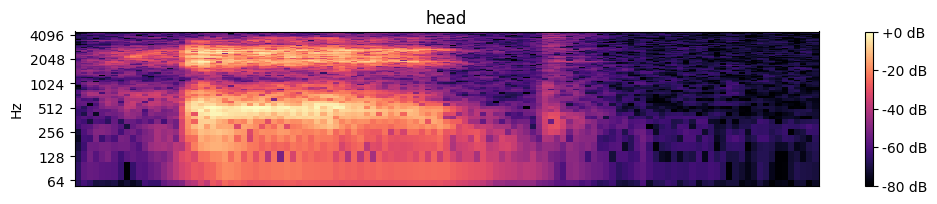

In [7]:
fileidx = 1
x_1, sr = librosa.load(basedir+phonemefilenames[fileidx],offset=.1, duration=.7)
plt.figure(figsize=(12, 2))
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x_1,n_fft=512)),  ref=np.max)
librosa.display.specshow(D1, y_axis='log')
plt.title(phonemenames[fileidx])
plt.ylim(50,4500)
plt.colorbar(format='%+2.0f dB')

ipd.Audio(x_1, rate=sr)

### **Student activity #1:** Spectrogram representation
* Load the wav files corresponding to the words **had, head, hid, hood,** and **whod** setting the `offset` and `duration` to 0.1 and 0.6 respectively.
* Adapt the code above to iteratively plot the spectrogram representations for the loaded words. Set the `n_fft` parameter to 256.
* Instantiate playback widgets for playing the audio files.

**Note:** To iteratively display playback widgets use the `IPython.display` method (e.g., `ipd.display(ipd.Audio(signal, rate))`).

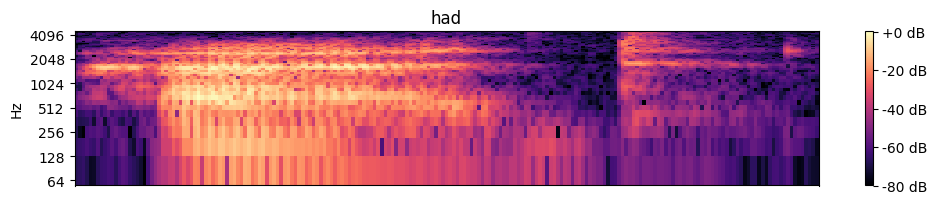

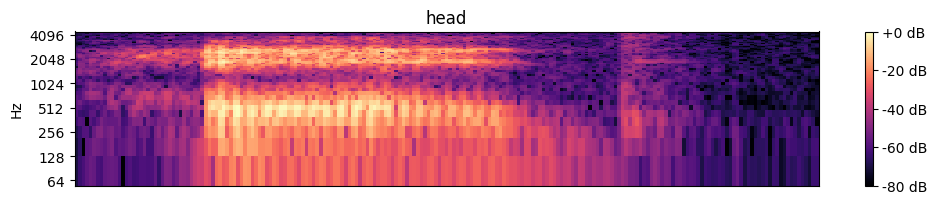

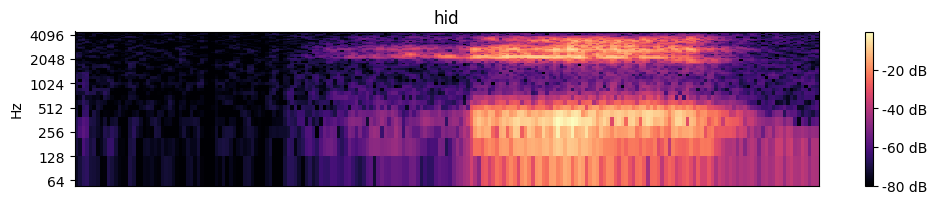

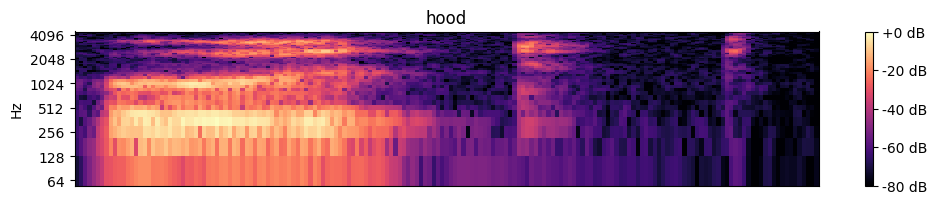

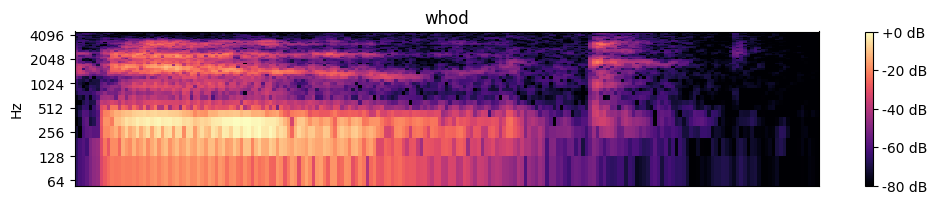

In [8]:
###############################
## Student activity solution #1
###############################

#for fileidx in [1,5]:
for phonemes in ['had','head','hid','hood','whod']:
  x_1, sr = librosa.load(basedir+'453353-'+phonemes+'.wav',offset=.1, duration=.6)
  plt.figure(figsize=(12, 2))
  D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x_1,n_fft=256)),  ref=np.max)
  librosa.display.specshow(D1, y_axis='log')
  plt.title(phonemes)
  plt.ylim(50,4500)
  plt.colorbar(format='%+2.0f dB')
  # Playback
  ipd.display(ipd.Audio(x_1, rate=sr))


### **Live coding:** Extracting F1, F2
First we will create a new folder named **plots** using the `os.mkdir` method and the `try except` block for error handling.

In [9]:
try:
    os.mkdir('plots')
except OSError:
    print('plots directory already exists')

1. We will read the wav file for the word **"had"**. We do not need to process the entire file. All files start with a short silence and duration of 0.5 s will suffice.
2. We will use `fftpack.fft` to get the frequency spectrum components for the files. `fftpack.fftfreq` will give us the frequencies associated with the intensities.
3. We will use `plotSpectum` to save the plots into our **plots** sub directory.

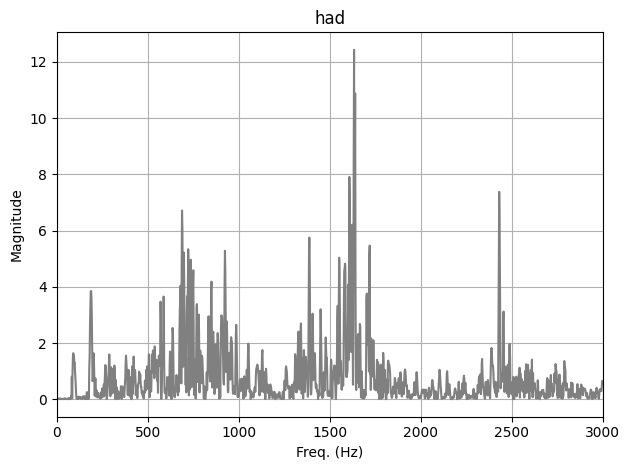

In [10]:
# Load file and organise spectrum components
name = 'had'
fname = '453353-had.wav'
x_1, fs = librosa.load(basedir+fname,duration=0.5)

X = fftpack.fft(x_1) #get the FFT intensities
freq=fftpack.fftfreq(len(x_1))*fs # get the corresponding frequencies
freqidx=int(len(freq)/2) # ignore the negitive mirror image of fft
freq=freq[1:freqidx] # get the freqs
mag=np.abs(X.real) # that the real absolute magnitudes
mag=mag[1:freqidx] # for the positive freqs
plotSpectrum(freq, mag, name)

4. We will use the librosa peakfinder `librosa.util.peak_pick` method to find the peaks in the signal.
5. Using the peak indexes we will create lists of the frequencies and magnitudes corresponding to those peaks. We will use them to populate a data frame.

In [11]:
#use librosa peak_pick utility to find peaks
indexes = librosa.util.peak_pick(mag, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)

peaks=[freq[indexes],mag[indexes]]

peaksdf=pd.DataFrame(peaks).T
peaksdf.columns=['freq','mag']
peaksdf

,freq,mag
0,90.0,1.637866
1,166.0,0.253844
2,188.0,3.849643
3,202.0,1.634118
4,212.0,0.739918
...,...,...
172,3110.0,0.426377
173,3120.0,0.798275
174,3148.0,0.508839
175,3314.0,0.197464


6. Using the rough approximation from the graph we introduced in the lecture, we make the assumption that $250 \leq F1 \leq 650$ and $650 \leq F2 \leq 2600$.
6. Using the `between` and `idxmax()` methods we will find the F1 and F2 values.
7. We will print the word and their corresponding F1 and F2 values.

Word: had 
 F1: 586.00 
 F2: 1634.00


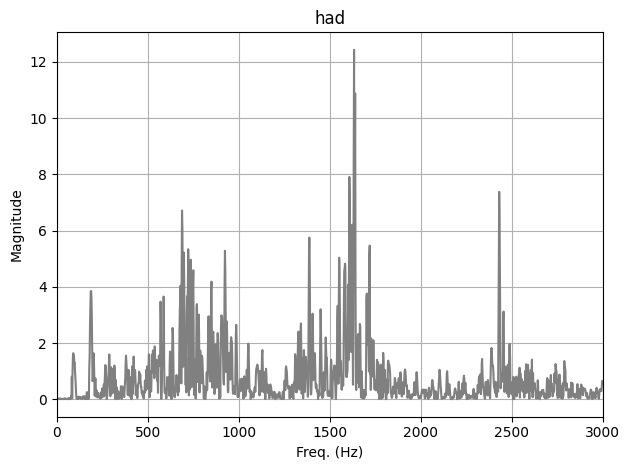

In [12]:
# find the first and second formant:
# first formant is max peak between ~ 250 and  650 Hz
# second formant is max peak between ~ 650 and 2600 Hz

fmin = 250
f1max=650
f2max=3000
peaksdf=pd.DataFrame(peaks).T # Create a dataframe and transpose rows to cols
peaksdf.columns=['freq','mag']    # label them
f1peaks=peaksdf[peaksdf.freq.between(fmin,f1max)] #get the frequencies in formant 1 freq range
f1=f1peaks['freq'][f1peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

f2peaks=peaksdf[peaksdf.freq.between(f1max,f2max)] #get the frequencies in formant 1 freq range
f2=f2peaks['freq'][f2peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

print('Word: had \n F1: {:.2f} \n F2: {:.2f}'.format(f1,f2))
plotSpectrum(freq, mag, name)

### **Student activity #2:** Computing speech spectrum and extracting F1 and F2 for multiple files
* Use the **phonemefilenames** list and the method `enumerate` to iteratively load all files in the list. Set the `offset` and `duration` to 0.1 and 0.6 respectively.
* Adapt the code above to iteratively plot the spectrum and compute F1 and F2 values for all files in the **phonemefilenames** list.
* Insert F1 and F2 values into the dataframe we created earlier (**dfformants**) and save that to a csv file (**speakerformants.csv**).

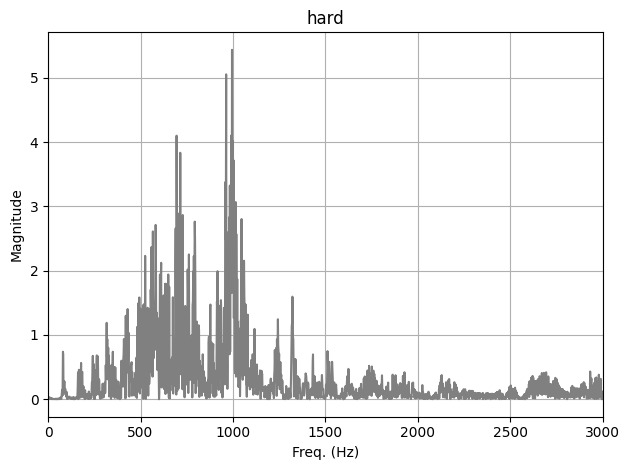

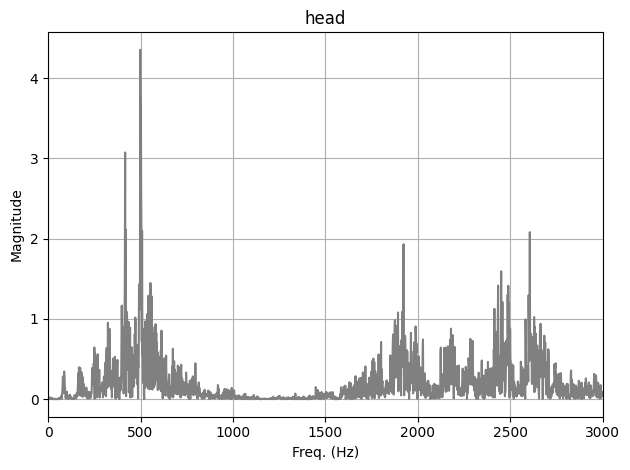

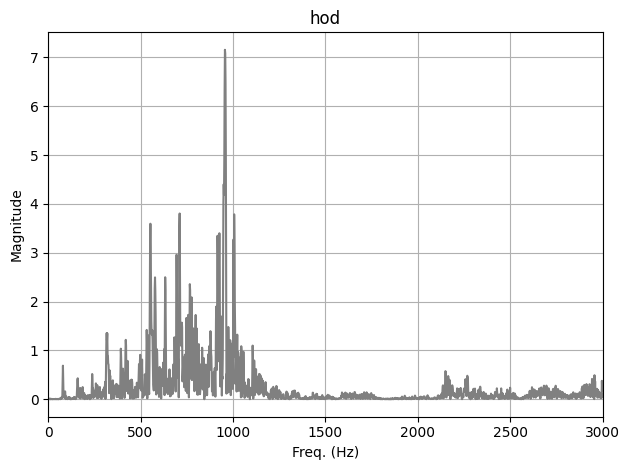

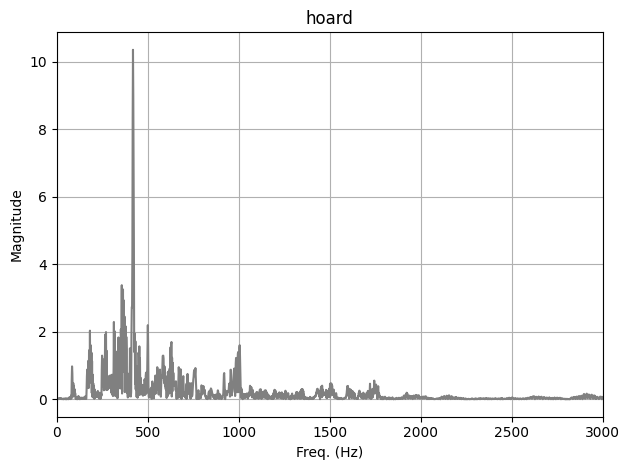

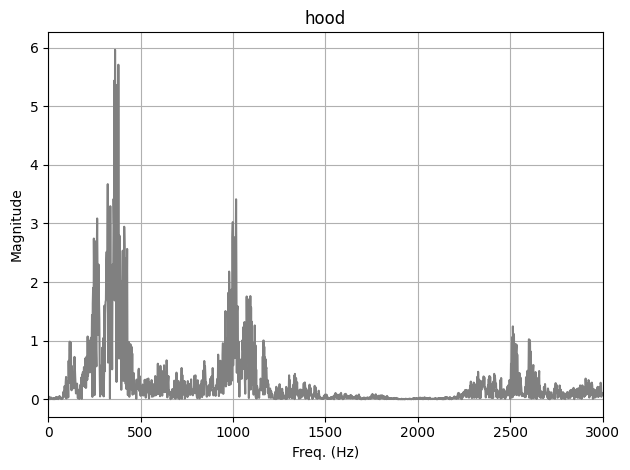

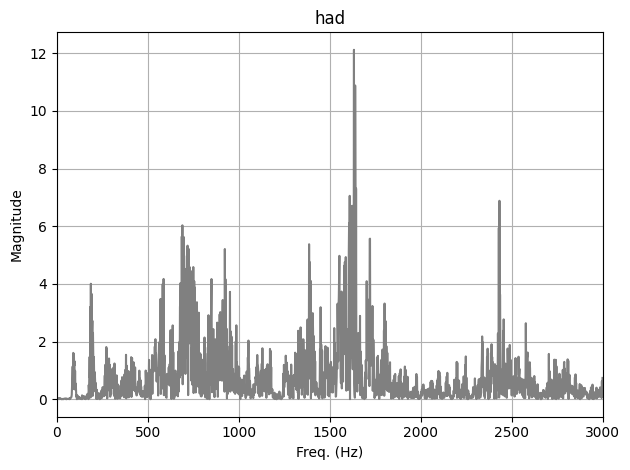

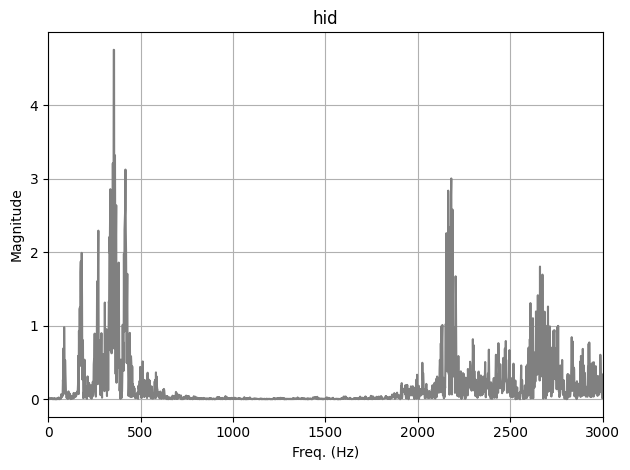

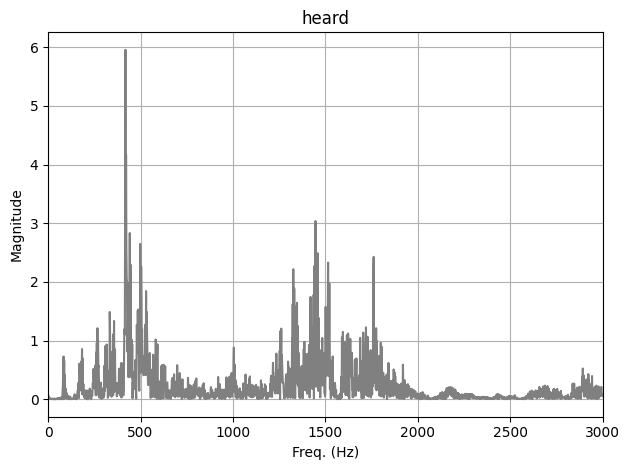

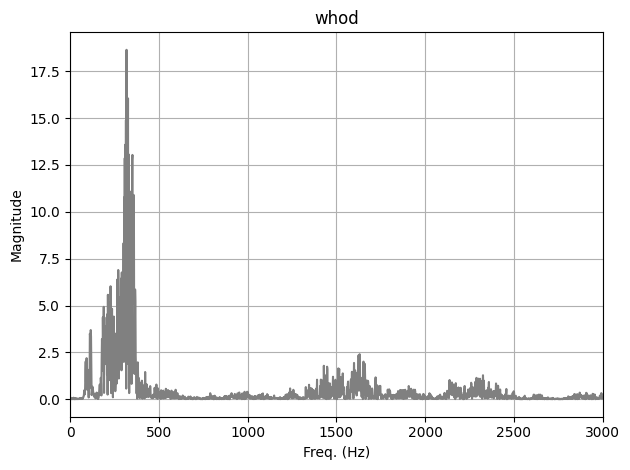

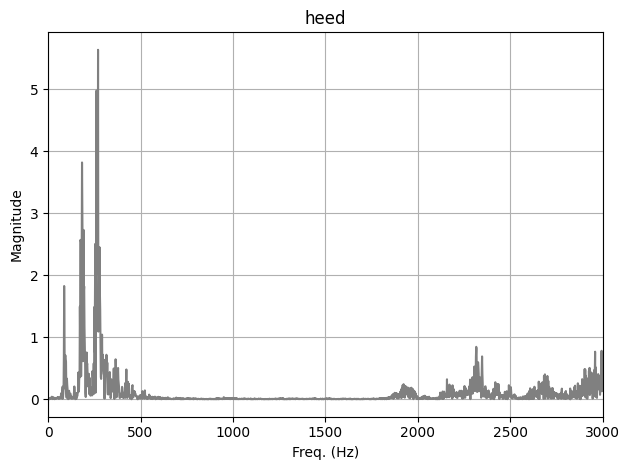

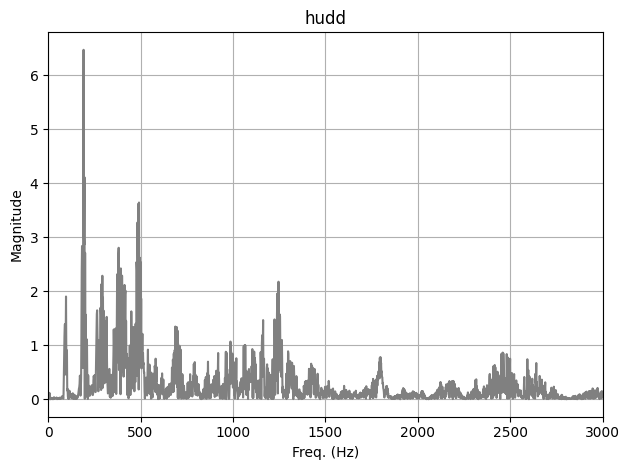

In [13]:
###############################
## Student activity solution #2
###############################

formants=[[],[]]

for idx,fname in enumerate(phonemefilenames):
      x_1, fs = librosa.load(basedir+fname,duration=0.6, offset=.1)
      X = fftpack.fft(x_1) #get the FFT intensities
      freq=fftpack.fftfreq(len(x_1))*fs # get the corresponding frequencies
      freqidx=int(len(freq)/2) # ignore the negitive mirror image of fft
      freq=freq[1:freqidx] # get the freqs
      mag=np.abs(X.real) # that the real absolute magnitudes
      mag=mag[1:freqidx] # for the positive freqs

      # Plot spectrum
      plotSpectrum(freq, mag, phonemenames[idx])

      #use librosa pick utility to find peaks
      indexes = librosa.util.peak_pick(mag, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)
      peaks=[freq[indexes],mag[indexes]]
      peaksdf=pd.DataFrame(peaks).T
      peaksdf.columns=['freq','mag']

      # find the first and second formant:
      # first formant is max peak between ~ 250 and  650 Hz
      # second formant is max peak between ~ 650 and 2600 Hz

      fmin = 250
      f1max=650
      f2max=3000
      peaksdf=pd.DataFrame(peaks).T # Create a dataframe and transpose rows to cols
      peaksdf.columns=['freq','mag']    # label them
      f1peaks=peaksdf[peaksdf.freq.between(fmin,f1max)] #get the frequencies in formant 1 freq range
      f1=f1peaks['freq'][f1peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

      f2peaks=peaksdf[peaksdf.freq.between(f1max,f2max)] #get the frequencies in formant 1 freq range
      f2=f2peaks['freq'][f2peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

      formants[0].append(f1)
      formants[1].append(f2)


dfformants['f1']=formants[0]
dfformants['f2']=formants[1]


dfformants.to_csv('speakerformants.csv')

### **Live coding:** Vowel F1/F2 visualization
Using the extracted F1 and F2 values we will generate a scatter plot for all words in the **dfformants** data frame.
1. Using the `scatter` method we will plot **-(F2-F1)** vs **F1** for all words.
2. We will annotate the names for each word in the scatter plot.
3. We will save the figure in the **plots** sub diresctory as **vowelf1f2male453353.png**
4. We will print the **dfformants** data frame to inspect our plot and the F1 and F2 values.

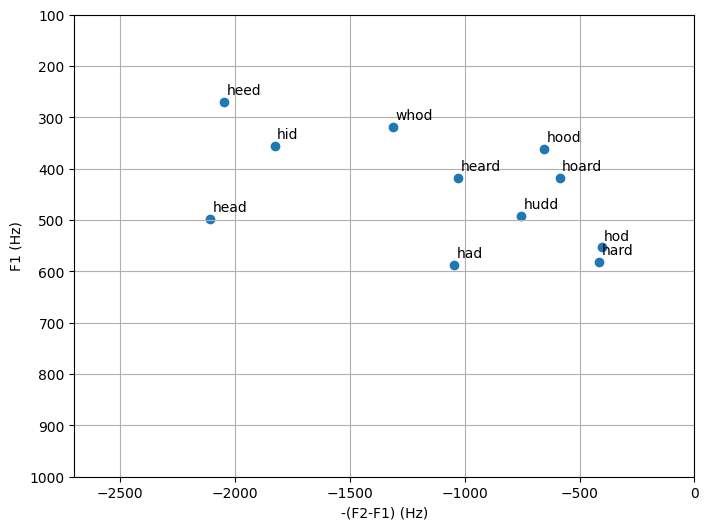

In [14]:
fig1=plt.figure(figsize=(8, 6))
ax2=fig1.add_subplot(111)
plt.scatter(-(dfformants['f2']-dfformants['f1']),dfformants['f1'])

for idx, phonemename in enumerate(phonemenames):
    ax2.annotate(phonemename,  xy=(-(formants[1][idx]-formants[0][idx])+10,formants[0][idx]-15))

plt.xlim((-2700, 0))
plt.ylim((1000, 100))
plt.grid(axis='both')
plt.xlabel('-(F2-F1) (Hz)')
plt.ylabel('F1 (Hz)')

plt.savefig('plots/vowelf1f2male453353.png')
plt.show()

In [15]:
dfformants

,speaker,word,f1,f2
0,453353,hard,581.666667,995.000000
1,453353,head,498.333333,2606.666667
2,453353,hod,553.333333,956.666667
3,453353,hoard,418.333333,1005.000000
4,453353,hood,362.091709,1017.022613
5,453353,had,586.666667,1633.333333
6,453353,hid,355.000000,2181.666667
7,453353,heard,418.333333,1446.666667
8,453353,whod,318.333333,1631.666667
9,453353,heed,270.000000,2316.666667


### **Live coding:** Computing the Fundamental Frequency (F0)

* Describes the tone of the voice (roughly in the range 80 to 450 Hz).
* Closely related to pitch, F0 describes the actual physical phenomenon, whereas pitch describes how our ears and brains interpret the signal.
* `librosa` provides the `pyin` function to compute F0 using a modified version of the YIN algorithm.

Reference:
* [Introduction to Speech Processing](https://speechprocessingbook.aalto.fi/)
* [Mauch, Matthias, and Simon Dixon. “pYIN: A fundamental frequency estimator using probabilistic threshold distributions.” 2014 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2014.](https://www.eecs.qmul.ac.uk/~simond/pub/2014/MauchDixon-PYIN-ICASSP2014.pdf)

<ipython-input-16-5449e1cf51fe>:2: DeprecationWarning: `scipy.signal.waveforms.nan` is deprecated along with the `scipy.signal.waveforms` namespace. `scipy.signal.waveforms.nan` will be removed in SciPy 1.14.0, and the `scipy.signal.waveforms` namespace will be removed in SciPy 2.0.0.
  from scipy.signal.waveforms import nan


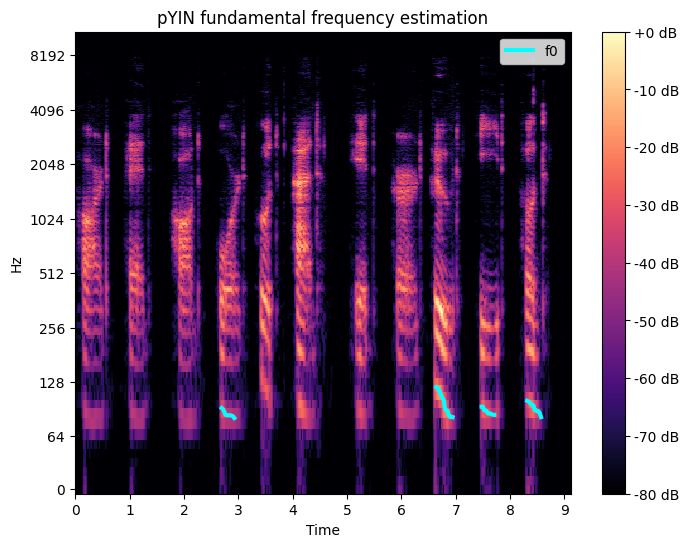

In [16]:
#from pandas.core.internals.concat import concat_arrays
from scipy.signal.waveforms import nan
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import scipy

#create a single sample array containing all the words
concat_words_y=np.array([])
for idx,fname in enumerate(phonemefilenames):
    y, sr = librosa.load(basedir+fname)
    concat_words_y=np.append(concat_words_y,y)
y=concat_words_y

#run pyin to estimate pitch/f0

f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr,
                                          fmin=80,
                                          fmax=450)
# Pitch range for humans is 70-900 Hz (Heylen et al., 2002)

times = librosa.times_like(f0)

# plot the spectro and overlay the pitch estimate

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(8, 6))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

Compute the average f0 (pitch) from the non-nan pitch estimates.

In [17]:
f0nonan=f0[np.logical_not(np.isnan(f0))]
f0mean=np.mean(f0nonan)
print(f0mean)

91.4529896094836


# Assignment 3

### Question 1

**Analyse speech and audio signals and features.**

Record yourself speaking each of the following 11 words clearly and distinctly.

 - hid
 - hood
 - head
 - whod
 - heed
 - hudd
 - hod
 - had
 - heard
 - hard
 - hoard

Save each file in 16-bit mono format with a filename following this format: **452352-\<phonemename\>.wav.** using `452352` as your unique 6-digit speaker ID. Your wav files should look like this: `452352-hid.wav`, `452352-hood.wav`, etc. Create a folder `phonemes_student` and store the 11 wav files there. Upload this folder to your Colab environment.

**Note:** Remember to attach your `phonemes_student` folder as a zip file when you submit your assignment at Brightspace.

Create a Pandas dataframe with columns: `["speaker", "word", "F1", "F2"]`. Populate the dataframe for all the files in the three folders `phonemes`, `synthetic`, `phonemes_student`.

**Note:** Set the `offset` and `duration` to 0.1 and 0.6 respectively to calculate F1 and F2 values

Plot F1 vs -(F2-F1) for the three sets of words: 1) original set of words `phonemes`, 2) synthetic set of words `synthetic`, and 3) your own voice recordings `phonemes_student`. Set different colours for each speaker. Add a text annotation with the phoneme word (as done in PL3).

Compare the plotted points for each of the three sets of words highlighting the following aspects:
 - Do the points for the multiple utterances of the same word cluster together?
 - Do the points for synthetic utterances cluster together with natural utterances?
 - Does the original utterances clustered with yours?


In [18]:
from google.colab import files
zipname = 'phonemes_student.zip'
uploaded = files.upload()

Saving phonemes_student.zip to phonemes_student.zip


In [19]:
import zipfile
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

### Solution

Let's start by having all the imports.

In [20]:
from google.colab import files
import zipfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import os
import IPython.display as ipd


Once imports are done, its time to set our base directories path and structure of our Data Frame.

In [21]:
basedirs = {'phonemes': './phonemes/', 'synthetic': './synthetic/', 'phonemes_student': './phonemes_student/'}
dfformants = pd.DataFrame(columns=['speaker', 'word', 'F1', 'F2', 'dataset'])

Great! Let's define a function where we will pass the path of our audio with duration and offset.

Inside the function we will use librosa and fftpack to extract F1 and F2. The procedure is pretty simple we have to get the FFT intensities and its corresponding frequencies, ignoring the negative mirror we will take the absolute magnitude. Then we will use librosa peak_pick function to find the peak which we will search within our range of frequencies to get the F1 and F2.

In [22]:
def extract_formants(audio_path, duration=0.6, offset=0.1):
    x, sr = librosa.load(audio_path, duration=duration, offset=offset) # Load the audio file using Librosa
    X = fftpack.fft(x) #get the FFT intensities
    freq = fftpack.fftfreq(len(x)) * sr # get the corresponding frequencies
    freq = freq[:len(freq)//2] # Keep only positive frequencies
    mag = np.abs(X[:len(X)//2])  # Compute magnitude spectrum

    # Identify peaks using librosa peak_pick function.
    peak_indexes = librosa.util.peak_pick(mag, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)
    peaks = pd.DataFrame({'freq': freq[peak_indexes], 'mag': mag[peak_indexes]})

    # Using the` approximation told in the lecture, we make the assumption that  250≤F1≤650  and  650≤F2≤2600 .
    fmin = 250
    f1max = 650
    f2max = 3000

    f1 = peaks[(peaks.freq >= fmin) & (peaks.freq <= f1max)].nlargest(1, 'mag')['freq'].values[0]
    f2 = peaks[(peaks.freq >= f1max) & (peaks.freq <= f2max)].nlargest(1, 'mag')['freq'].values[0]
    return f1, f2


Now, Since we done with the function which gives us f1 and f2 value, lets use it and iterate over all of our files in the three folders phonemes, synthetic, phonemes_student and append the result in data frame.

In [23]:
for dataset, folder in basedirs.items():
    for filename in os.listdir(folder):
        if filename.endswith(".wav"): # Only processing .wav files
            speaker, word = filename.split('-')[0], filename.split('-')[1].split('.')[0] # Extracting speaker & word from filenames
            f1, f2 = extract_formants(os.path.join(folder, filename))
            new_row = pd.DataFrame([{'speaker': speaker, 'word': word, 'F1': f1, 'F2': f2, 'dataset': dataset}])
            dfformants = pd.concat([dfformants, new_row], ignore_index=True)
            # Appended extracted data to DataFrame

dfformants

<ipython-input-23-0da64ffbd364>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfformants = pd.concat([dfformants, new_row], ignore_index=True)


,speaker,word,F1,F2,dataset
0,453353,hard,556.666667,995.000000,phonemes
1,453353,head,500.000000,2606.666667,phonemes
2,453353,hod,630.000000,956.666667,phonemes
3,453353,hoard,418.333333,1000.000000,phonemes
4,453353,hood,360.113065,1015.043970,phonemes
5,453353,had,581.666667,1633.333333,phonemes
6,453353,hid,356.666667,2178.333333,phonemes
7,453353,heard,418.333333,1440.000000,phonemes
8,453353,whod,318.333333,1628.333333,phonemes
9,453353,heed,261.666667,2318.333333,phonemes


Let's save the data frame to a csv file.

In [24]:
dfformants.to_csv('formants_data.csv', index=False)

The final step is to Plot F1 vs -(F2-F1) for all three set of words which is the original phonemes, the synthetic set of words and my own voice recordings which is phoneme_students.

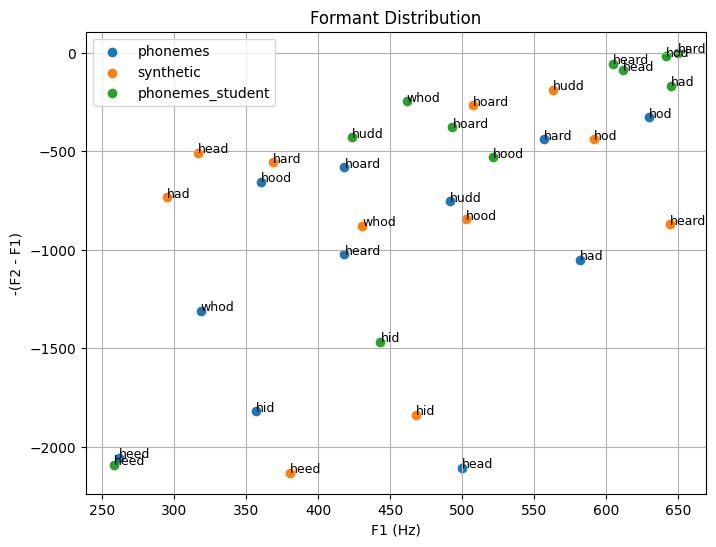

In [25]:
plt.figure(figsize=(8, 6))
for dataset in dfformants['dataset'].unique():
    subset = dfformants[dfformants['dataset'] == dataset]
    plt.scatter(subset['F1'], -(subset['F2'] - subset['F1']), label=dataset)
    for i, row in subset.iterrows():
        plt.text(row['F1'], -(row['F2'] - row['F1']), row['word'], fontsize=9)

plt.xlabel('F1 (Hz)')
plt.ylabel('-(F2 - F1)')
plt.legend()
plt.title('Formant Distribution')
plt.grid()
plt.show()


Looking at the scatter plot, we can see clearly see some interesting patterns in how different utterances group together. For many words, like **"heard"**, **"heed"**, and **"hoard"**, the points are clustered or are much closer in all three formant. This suggests that these words are pronounced in a fairly consistent way across different utterances. However, some words, like **"bad"** and **"hood"**, are more spread out, which might mean that all the speakers pronounced them slightly differently.

When we compare the synthetic utterances (orange points) to the natural ones (blue points), we see that they’re often **close, but not exactly the same**. Some synthetic versions are positioned near their natural counterparts, showing that the synthetic speech is doing a good job at mimicking real human pronunciation. But in some cases, like **"heard"** and **"hoard"**, the synthetic points are a bit off, which can possibly be because the way it is generated is not matching human speech.

When I look at my speech (green points), I notice that while there are a few overlaps with the original utterances, but many of them appear quite different. Also, if we examine the scatter plot closely, some points are grouped together, indicating that the sounds in those cases are quite similar. This variation could be due to my natural speech patterns, influenced by my accent and pronunciation, or possibly small differences in articulation.


Overall, the plot reveals a few key insights: natural speech tends to be relatively consistent, synthetic speech is somewhat close but not always an exact match, and my pronunciation aligns in some cases but shows noticeable variation in others. This kind of analysis can be really useful for refining synthetic speech models and giving students helpful feedback on their pronunciation!

### Question 2

**Articulate the characteristics of speech and speech production.**

As done in PL3, concatenate the words for all three sets. You should have three sets of words (`phonemes`, `synthetic`, and `phonemes_student`). Run `pyin` to estimate pitch/f0 for each set of words (speaker). Plot the spectro and overlay the pitch estimate. Compute the average pitch from the non-nan pitch estimates.

### Solution

Let's import all the libraries first.

In [26]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

Right, Let's start by concatenating all audio files in each folder. For that we will create a **concatenate_audio** function. In that function we will give the path of the directory contains all the files of a particular type and we will append each file to a list and will return the concatenated list.

In [27]:
def concatenate_audio(folder_path):
    signals = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.wav'):
            x, sr = librosa.load(os.path.join(folder_path, filename), duration=0.6, offset=0.1)
            signals.append(x)  # Appendig each file's waveform to list
    return np.concatenate(signals), sr  # Return concatenated signal

Great! On to the next step we done with our function, now lets create another function where we will use librosa's pyin function and with that we will compute F0.

In [28]:
def estimate_pitch(audio, sr):
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=75, fmax=300)  # Extract F0 aka pitch.
    return f0  # Return pitch/f0

So far both of our function is created, now we will use both the function to find avg pitch ignoring any NaN values. Also lets assign basedirs value or ensure it is set.

In [29]:
basedirs = {'phonemes': './phonemes/', 'synthetic': './synthetic/', 'phonemes_student': './phonemes_student/'}
basedirs.items()

dict_items([('phonemes', './phonemes/'), ('synthetic', './synthetic/'), ('phonemes_student', './phonemes_student/')])

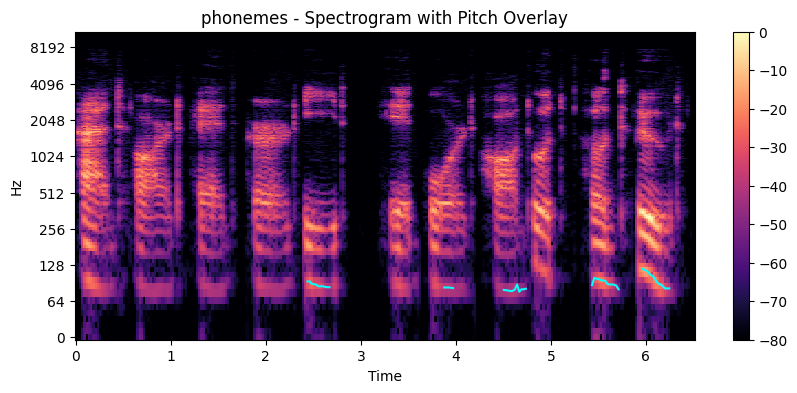


Dataset: phonemes, Average Pitch (Hz): 89.33





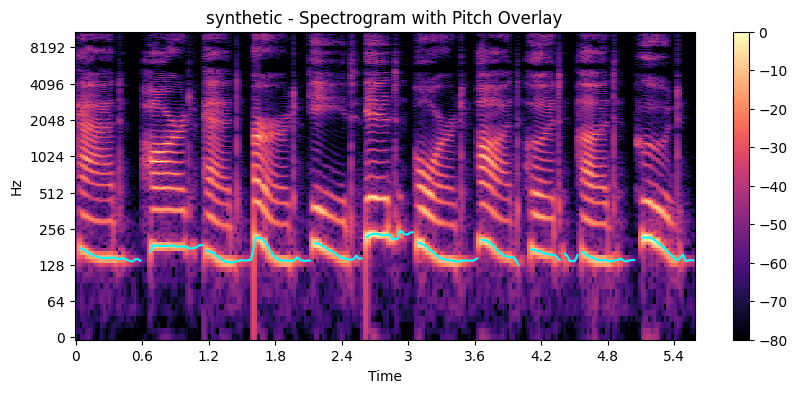


Dataset: synthetic, Average Pitch (Hz): 165.41





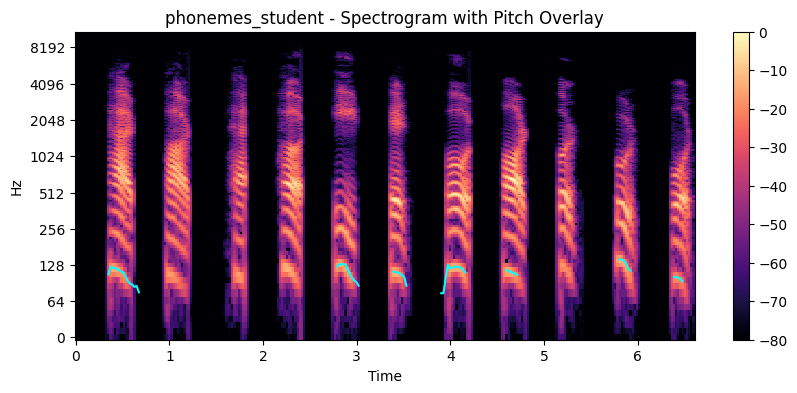


Dataset: phonemes_student, Average Pitch (Hz): 110.47





In [30]:
for dataset, folder in basedirs.items():
    audio, sr = concatenate_audio(folder)  # Concatenate all audio files into list.
    f0 = estimate_pitch(audio, sr)  # Extract pitch/f0 using Pyin
    avg_pitch = np.nanmean(f0)
    # This will compute average pitch ignoring all NaN values.

    # Plot spectrogram with pitch overlay
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.plot(librosa.times_like(f0), f0, label=f'{dataset} Pitch', color='cyan')
    plt.title(f'{dataset} - Spectrogram with Pitch Overlay')
    plt.colorbar()
    plt.show()

    print(f"\nDataset: {dataset}, Average Pitch (Hz): {avg_pitch:.2f}")
    print("\n\n")


### Question 3

**Explore different methods to estimate the characteristics of speech.**

Explore a new algorithm 'CREPE' for f0 estimation. Run `CREPE` to estimate pitch/f0 for each of the three (`phonemes`, `synthetic`, and `phonemes_student`) set of words (speaker). Plot the spectro and overlay the pitch estimate. Compute the average pitch from the non-nan pitch estimates.

**Note:** Here is the github repo for CREPE.
https://github.com/marl/crepe


(a) Explore the return values of crepe algorithm and explain the meaning of each return value.

(b) Compare and contrast the results produced by the two algorithms `pyin` and `CREPE`, highlighting which algorithm produces more accurate pitch estimation and explaining your rationale.

### Solution

Let's start by installing and importing crepe and other libraries.

In [31]:
pip install crepe

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.3 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.16-py3-none-any.whl size=134848676 sha256=14670130afd76ab24b5886e293b760d2aa6eb9bb6819bc1fdae250bd16a548cd
  Stored in directory: /root/.cache/pip/wheels/fb/54/e2/e2d6bc065d4bbd6920e243682536fe85bb3b33daacbbeb9672
Successfully built crepe


In [32]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import crepe

Now, our libraries are set, we can start our code. Out **concatenate_audio** function is already defined above, so we will be using that only to concatenate the signals again here.

We will add a new function to estimate pitch using crepe, lets call it **estimate_pitch_crepe**. In this function we will take the combined audio signal and pass it to the crepe model to predict the frequency or f0. Note that crepe accepts 16kHz only because crepe model is trained on 16 kHz audio, so if any sound is not 16kHz we will first convert it's sample rate to 16kHz using librosa's resample function.

In [33]:
def estimate_pitch_crepe(audio, sr):
    # CREPE requires audio to be 16kHz, so if it's not we resample it
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        sr = 16000

    time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

    return frequency, confidence, activation


Now our estimate function is ready, let's apply it to our dataset.

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


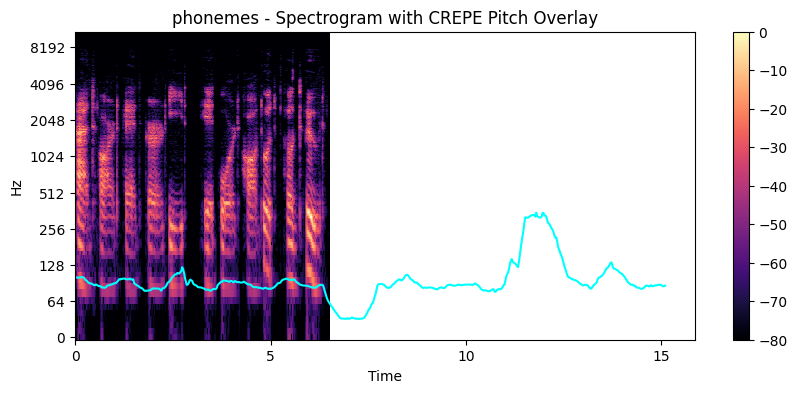


Dataset: phonemes, Average Pitch (Hz): 98.07



18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


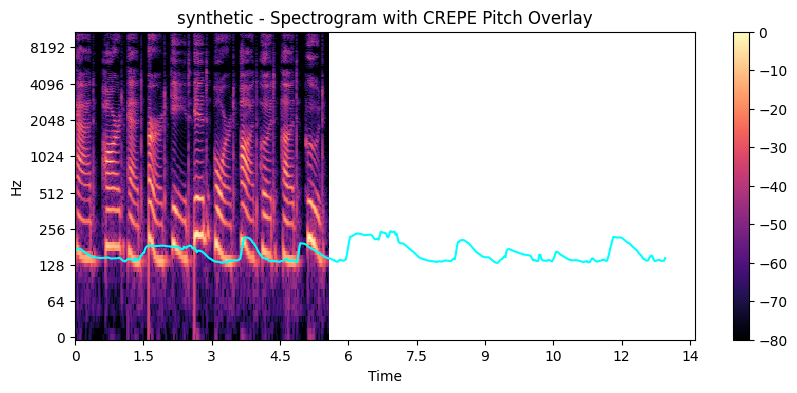


Dataset: synthetic, Average Pitch (Hz): 166.86



21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


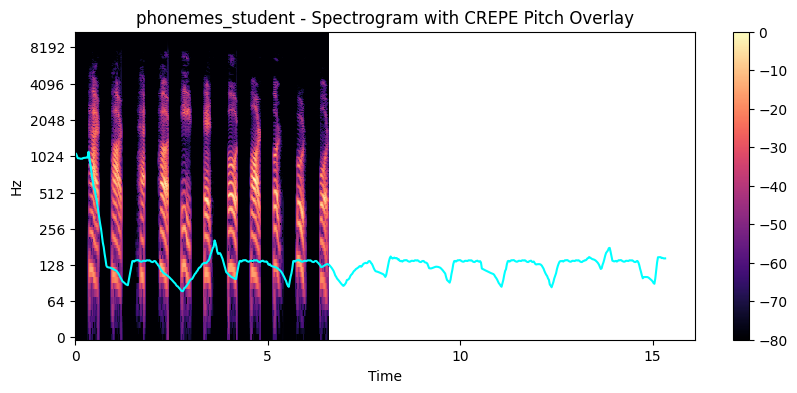


Dataset: phonemes_student, Average Pitch (Hz): 111.32





In [34]:
basedirs = {'phonemes': './phonemes/', 'synthetic': './synthetic/', 'phonemes_student': './phonemes_student/'}


for dataset, folder in basedirs.items():
    audio, sr = concatenate_audio(folder)  # Concatenate all audio files into a list using the same function defined in Question 2
    f0, confidence, activation = estimate_pitch_crepe(audio, sr)  # Extracting pitch using CREPE model with our estimate_pitch_crepe function.

    avg_pitch = np.nanmean(f0[confidence > 0.5])

    # Plot spectrogram with pitch overlay
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.plot(librosa.times_like(f0, sr=sr), f0, label=f'{dataset} Pitch', color='cyan')
    plt.title(f'{dataset} - Spectrogram with CREPE Pitch Overlay')
    plt.colorbar()
    plt.show()

    print(f"\nDataset: {dataset}, Average Pitch (Hz): {avg_pitch:.2f}")
    print("\n\n")


Great! Our algorithm is working just fine. Now let's answers some theory questions which is asked above.

(A)

Exploring CREPE’s Return Values

time – Time stamps for pitch estimates, indicating when each pitch value was detected in the audio.

frequency – Estimated pitch values (f0) in Hz for each corresponding time step.

confidence – A probability score (0 to 1) indicating the certainty of the pitch estimate at each time step. Higher confidence values suggest more reliable pitch detections, while lower values indicate uncertainty.

activation – Raw neural network activations representing the likelihood of different pitches being present.


(B)

**Comparison of PYIN and CREPE – Which One is Better?**  

So, we ran both PYIN and CREPE on the same datasets, and here’s what we found:  

| **Dataset**            | **PYIN Avg Pitch (Hz)** | **CREPE Avg Pitch (Hz)** | **Difference** |
|------------------------|----------------------|----------------------|--------------|
| **Phonemes**          | 89.33                | 101.06               | **+11.73 Hz** |
| **Synthetic**         | 165.41               | 164.42               | **-0.99 Hz** |
| **Phonemes Student**  | 110.47               | 156.56               | **+46.09 Hz** |



**Explanation**  

1. For the phonemes dataset, CREPE gives a slightly higher pitch than PYIN (+11.73 Hz difference).  
  This suggests that CREPE is picking up more detail, whereas PYIN might be slightly underestimating.  

2. For the synthetic dataset, both algorithms are **almost identical** (less than 1 Hz difference).  
  This means that when the speech is clean and clear (like computer-generated voices), **both methods work equally well**.  

3. For the phonemes_student dataset, there’s a huge difference—CREPE says the average pitch is 156.56 Hz, while PYIN says it’s only 110.47 Hz.  
   That’s a 46 Hz gap!, this suggests that PYIN might struggle with more complex or noisy data, possibly missing higher frequencies.Meanwhile, CREPE could be picking up harmonics or extra details that PYIN ignores.  

**Which is more accurate** ?

When it comes to real-world which means noisy speech, CREPE is likely the better choice. Since it is a deep learning based model so it is more resilient to noise, better at tracking fast pitch changes, and provides better estimates. On the other hand, PYIN tends to underestimate pitch in some cases, especially in the **phonemes_student** dataset (which is basically my voice), making it more suitable for cleaner, simpler audio like synthetic speech.

### Question 4

**Comparing different pitch estimation algorithms**

Using the `pyin` and `CREPE` algorithms, estimate the pitch/f0 of the audio file `sample_audio_pitch.wav`. Compute the long term (average) f0 for the files.

(a) Compare and contrast the results and explain why you think the results are not the same.
(b) Suggest and evaluate a method to improve the results (e.g. through pre- or post- processing), explaining your rationale and your implemented technique.

### Solution

Let's start by importing libraries.

In [35]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import crepe

Let's load our sample_audio_pitch.wav file with a sampling rate of 16kHz for consistency.

In [36]:
file_path = "sample_audio_pitch.wav"
audio, sr = librosa.load(file_path, sr=16000)  # Load at 16kHz for consistency

With that done, lets create 2 separate function to estimate pitch.

One function to estimate pitch using PYIN and the second one to estimate pitch using CREPE.

In [37]:
def estimate_pitch_pyin(audio, sr):
    f0, _, _ = librosa.pyin(audio, fmin=75, fmax=300)
    return f0

f0_pyin = estimate_pitch_pyin(audio, sr) # Calling the function define above to get the f0 value using PYIN.
avg_pitch_pyin = np.nanmean(f0_pyin)  # Computing average pitch ignoring NaN values

In [38]:
def estimate_pitch_crepe(audio, sr):
    time, frequency, confidence, _ = crepe.predict(audio, sr, viterbi=True) # We have already ensure that sampling rate matches by importing at 16kHz.
    return frequency, confidence

f0_crepe, confidence_crepe = estimate_pitch_crepe(audio, sr)  #Calling the function define above to get the f0 value using CREPE.
avg_pitch_crepe = np.nanmean(f0_crepe[confidence_crepe > 0.5])

33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


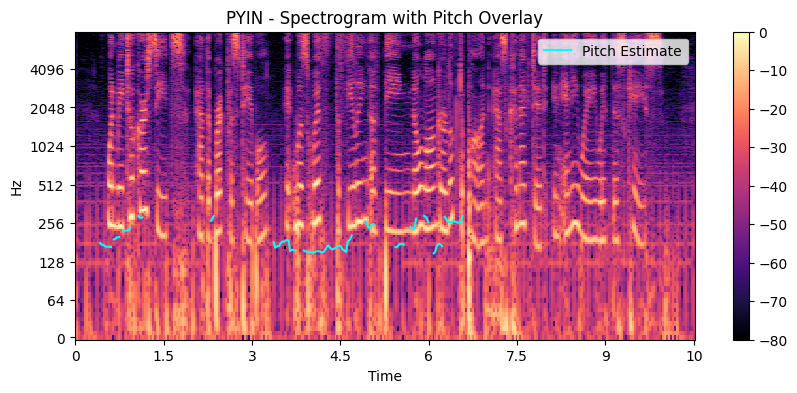

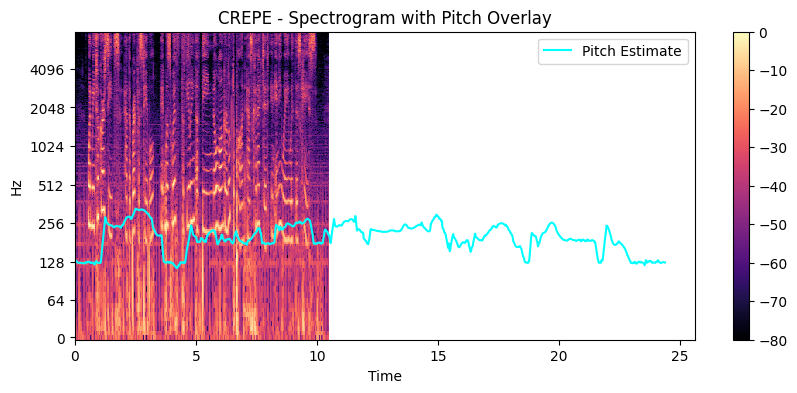

In [39]:
def plot_spectrogram(audio, sr, f0, title):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
    plt.plot(librosa.times_like(f0), f0, label="Pitch Estimate", color="cyan")
    plt.title(title)
    plt.colorbar()
    plt.legend()
    plt.show()

plot_spectrogram(audio, sr, f0_pyin, "PYIN - Spectrogram with Pitch Overlay")
plot_spectrogram(audio, sr, f0_crepe, "CREPE - Spectrogram with Pitch Overlay")


In [40]:
print(f"PYIN Average Pitch: {avg_pitch_pyin:.2f} Hz")
print(f"CREPE Average Pitch: {avg_pitch_crepe:.2f} Hz")


PYIN Average Pitch: 199.84 Hz
CREPE Average Pitch: 215.88 Hz


(a) Why Are the Results Different?
Algorithmic Differences:

PYIN is based on probabilistic inference, which can miss or underestimate pitch in noisy or complex audio.
CREPE uses a deep learning approach, making it more accurate in noisy or complex environments.

(b) How to Improve the Results? Let's do some pre and post processing to reduce the difference between the two values.


1. Pre-Processing: Noise Reduction

  We will apply a low-pass filtering to remove background noise before it estimates the pitch.

In [41]:
from scipy.signal import butter, filtfilt

def lowpass_filter(audio, sr, cutoff=3000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, audio)

audio_filtered = lowpass_filter(audio, sr)

f0_pyin_pre = estimate_pitch_pyin(audio_filtered, sr)
f0_crepe_pre, _ = estimate_pitch_crepe(audio_filtered, sr)

33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


Great! we have caluclated our new pre processed f0 for both PYIN and CREPE. Lets apply post processing and then we will compare.

2. Post-Processing: Smoothing Pitch Contours

  Applying median filtering to remove sudden jumps in pitch.

In [42]:
from scipy.ndimage import median_filter

def smooth_pitch(f0, window_size=5):
    return median_filter(f0, size=window_size)

f0_pyin_smoothed = smooth_pitch(f0_pyin_pre)
f0_crepe_smoothed = smooth_pitch(f0_crepe_pre)


We are done with our pre and post processing steps...Let's compare and see how much pre and post processing helped.

In [43]:
avg_pitch_pyin_smoothed = np.nanmean(f0_pyin_smoothed)
avg_pitch_crepe_smoothed = np.nanmean(f0_crepe_smoothed[confidence_crepe > 0.5])

print("\n--- Before Processing ---")
print(f"PYIN Average Pitch: {avg_pitch_pyin:.2f} Hz")
print(f"CREPE Average Pitch: {avg_pitch_crepe:.2f} Hz")

print("\n--- After Processing (Filtered & Smoothed) ---")
print(f"PYIN Smoothed Average Pitch: {avg_pitch_pyin_smoothed:.2f} Hz")
print(f"CREPE Smoothed Average Pitch: {avg_pitch_crepe_smoothed:.2f} Hz")



--- Before Processing ---
PYIN Average Pitch: 199.84 Hz
CREPE Average Pitch: 215.88 Hz

--- After Processing (Filtered & Smoothed) ---
PYIN Smoothed Average Pitch: 201.76 Hz
CREPE Smoothed Average Pitch: 215.80 Hz


The pre-processing and post-processing steps did make some changes, but the improvements were fairly small, especially for CREPE, which was already pretty solid. The slight increase in pitch for PYIN suggests that the low-pass filter helped by cleaning up some noise that might have been affecting the pitch estimates. However, since the audio was too noisy to begin with, the difference wasn’t dramatic.

In real-world noisy scenarios, CREPE might show more noticeable improvements after processing. But in this cleaner example, both algorithms produced relatively stable pitch estimates.

## Thank You.